In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt

from utils import mnist
import numpy as np

In [21]:
def plot_train_test(logs, tpe='loss'):
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for index, log in enumerate(logs):
        keys = log.keys()
        logs = {k:[z for z in zip(*log[k])] for k in keys}
        epochs = {k:range(len(log[k])) for k in keys}

        if tpe == 'loss':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label="train" if index==0 else "test") for k in keys])
            plt.title('errors')
            plt.xlabel('epoch')
            plt.ylabel('error')

        elif tpe == 'accuracy':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
            plt.title('accuracy')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            
    plt.legend()
    plt.show()

In [3]:
train_loader, test_loader = mnist()

In [4]:
class Net(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
#         self.fc5 = nn.Linear(64, 64)
#         self.fc6 = nn.Linear(64, 64)
#         self.fc7 = nn.Linear(64, 64)
#         self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(100, 10)
        self.optim = optim.SGD(self.parameters(), lr=0.5)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
#         x = torch.sigmoid(self.fc5(x))
#         x = torch.sigmoid(self.fc6(x))
#         x = torch.sigmoid(self.fc7(x))
#         x = torch.sigmoid(self.fc8(x))
        x = self.fc9(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models, log=None):
#     train_size = len(train_loader.sampler)
    train_size = 1000
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    limit = train_size / 100
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx == limit:
            break
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            train_loss[k] = loss.item()
            loss.backward()
            model.optim.step()
            pred = output.data.max(1, keepdim=True)[1]
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        if batch_idx % 1 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    if log is not None:
        for k in models:
            log[k].append((train_loss[k], correct_pct[k]))

In [6]:
models = {'default': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 500):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/1000 (0%)]	Losses default: 2.341937
Train Epoch: 1 [100/1000 (0%)]	Losses default: 2.368420
Train Epoch: 1 [200/1000 (0%)]	Losses default: 2.372657
Train Epoch: 1 [300/1000 (0%)]	Losses default: 2.429756
Train Epoch: 1 [400/1000 (0%)]	Losses default: 2.385731
Train Epoch: 1 [500/1000 (0%)]	Losses default: 2.305861
Train Epoch: 1 [600/1000 (1%)]	Losses default: 2.318805
Train Epoch: 1 [700/1000 (1%)]	Losses default: 2.383344
Train Epoch: 1 [800/1000 (1%)]	Losses default: 2.478520
Train Epoch: 1 [900/1000 (1%)]	Losses default: 2.359274
Test set:
default: Loss: 2.4409	Accuracy: 1028.0/10000 (10%)

Train Epoch: 2 [0/1000 (0%)]	Losses default: 2.415760
Train Epoch: 2 [100/1000 (0%)]	Losses default: 2.405456
Train Epoch: 2 [200/1000 (0%)]	Losses default: 2.351590
Train Epoch: 2 [300/1000 (0%)]	Losses default: 2.406698
Train Epoch: 2 [400/1000 (0%)]	Losses default: 2.363751
Train Epoch: 2 [500/1000 (0%)]	Losses default: 2.302651
Train Epoch: 2 [600/1000 (1%)]	Losses default:

Train Epoch: 14 [900/1000 (1%)]	Losses default: 2.294511
Test set:
default: Loss: 2.3370	Accuracy: 1028.0/10000 (10%)

Train Epoch: 15 [0/1000 (0%)]	Losses default: 2.329462
Train Epoch: 15 [100/1000 (0%)]	Losses default: 2.322540
Train Epoch: 15 [200/1000 (0%)]	Losses default: 2.304283
Train Epoch: 15 [300/1000 (0%)]	Losses default: 2.323295
Train Epoch: 15 [400/1000 (0%)]	Losses default: 2.308843
Train Epoch: 15 [500/1000 (0%)]	Losses default: 2.300408
Train Epoch: 15 [600/1000 (1%)]	Losses default: 2.306668
Train Epoch: 15 [700/1000 (1%)]	Losses default: 2.342911
Train Epoch: 15 [800/1000 (1%)]	Losses default: 2.341408
Train Epoch: 15 [900/1000 (1%)]	Losses default: 2.294137
Test set:
default: Loss: 2.3350	Accuracy: 1028.0/10000 (10%)

Train Epoch: 16 [0/1000 (0%)]	Losses default: 2.327955
Train Epoch: 16 [100/1000 (0%)]	Losses default: 2.321586
Train Epoch: 16 [200/1000 (0%)]	Losses default: 2.303700
Train Epoch: 16 [300/1000 (0%)]	Losses default: 2.321763
Train Epoch: 16 [400/1000

Test set:
default: Loss: 2.3208	Accuracy: 1028.0/10000 (10%)

Train Epoch: 28 [0/1000 (0%)]	Losses default: 2.316946
Train Epoch: 28 [100/1000 (0%)]	Losses default: 2.314675
Train Epoch: 28 [200/1000 (0%)]	Losses default: 2.301485
Train Epoch: 28 [300/1000 (0%)]	Losses default: 2.310088
Train Epoch: 28 [400/1000 (0%)]	Losses default: 2.302084
Train Epoch: 28 [500/1000 (0%)]	Losses default: 2.302017
Train Epoch: 28 [600/1000 (1%)]	Losses default: 2.302613
Train Epoch: 28 [700/1000 (1%)]	Losses default: 2.336725
Train Epoch: 28 [800/1000 (1%)]	Losses default: 2.322151
Train Epoch: 28 [900/1000 (1%)]	Losses default: 2.291858
Test set:
default: Loss: 2.3201	Accuracy: 1028.0/10000 (10%)

Train Epoch: 29 [0/1000 (0%)]	Losses default: 2.316352
Train Epoch: 29 [100/1000 (0%)]	Losses default: 2.314264
Train Epoch: 29 [200/1000 (0%)]	Losses default: 2.301486
Train Epoch: 29 [300/1000 (0%)]	Losses default: 2.309448
Train Epoch: 29 [400/1000 (0%)]	Losses default: 2.301841
Train Epoch: 29 [500/1000

Train Epoch: 41 [900/1000 (1%)]	Losses default: 2.291235
Test set:
default: Loss: 2.3133	Accuracy: 1028.0/10000 (10%)

Train Epoch: 42 [0/1000 (0%)]	Losses default: 2.310626
Train Epoch: 42 [100/1000 (0%)]	Losses default: 2.309855
Train Epoch: 42 [200/1000 (0%)]	Losses default: 2.301943
Train Epoch: 42 [300/1000 (0%)]	Losses default: 2.303414
Train Epoch: 42 [400/1000 (0%)]	Losses default: 2.300025
Train Epoch: 42 [500/1000 (0%)]	Losses default: 2.302758
Train Epoch: 42 [600/1000 (1%)]	Losses default: 2.299983
Train Epoch: 42 [700/1000 (1%)]	Losses default: 2.333209
Train Epoch: 42 [800/1000 (1%)]	Losses default: 2.314322
Train Epoch: 42 [900/1000 (1%)]	Losses default: 2.291207
Test set:
default: Loss: 2.3130	Accuracy: 1028.0/10000 (10%)

Train Epoch: 43 [0/1000 (0%)]	Losses default: 2.310297
Train Epoch: 43 [100/1000 (0%)]	Losses default: 2.309576
Train Epoch: 43 [200/1000 (0%)]	Losses default: 2.301984
Train Epoch: 43 [300/1000 (0%)]	Losses default: 2.303077
Train Epoch: 43 [400/1000

Train Epoch: 54 [900/1000 (1%)]	Losses default: 2.290917
Test set:
default: Loss: 2.3098	Accuracy: 1028.0/10000 (10%)

Train Epoch: 55 [0/1000 (0%)]	Losses default: 2.307137
Train Epoch: 55 [100/1000 (0%)]	Losses default: 2.306753
Train Epoch: 55 [200/1000 (0%)]	Losses default: 2.302347
Train Epoch: 55 [300/1000 (0%)]	Losses default: 2.299878
Train Epoch: 55 [400/1000 (0%)]	Losses default: 2.299331
Train Epoch: 55 [500/1000 (0%)]	Losses default: 2.303042
Train Epoch: 55 [600/1000 (1%)]	Losses default: 2.298372
Train Epoch: 55 [700/1000 (1%)]	Losses default: 2.330694
Train Epoch: 55 [800/1000 (1%)]	Losses default: 2.310843
Train Epoch: 55 [900/1000 (1%)]	Losses default: 2.290894
Test set:
default: Loss: 2.3096	Accuracy: 1028.0/10000 (10%)

Train Epoch: 56 [0/1000 (0%)]	Losses default: 2.306926
Train Epoch: 56 [100/1000 (0%)]	Losses default: 2.306557
Train Epoch: 56 [200/1000 (0%)]	Losses default: 2.302366
Train Epoch: 56 [300/1000 (0%)]	Losses default: 2.299667
Train Epoch: 56 [400/1000

Train Epoch: 67 [900/1000 (1%)]	Losses default: 2.290615
Test set:
default: Loss: 2.3078	Accuracy: 1028.0/10000 (10%)

Train Epoch: 68 [0/1000 (0%)]	Losses default: 2.304834
Train Epoch: 68 [100/1000 (0%)]	Losses default: 2.304561
Train Epoch: 68 [200/1000 (0%)]	Losses default: 2.302511
Train Epoch: 68 [300/1000 (0%)]	Losses default: 2.297562
Train Epoch: 68 [400/1000 (0%)]	Losses default: 2.298960
Train Epoch: 68 [500/1000 (0%)]	Losses default: 2.303134
Train Epoch: 68 [600/1000 (1%)]	Losses default: 2.297255
Train Epoch: 68 [700/1000 (1%)]	Losses default: 2.328701
Train Epoch: 68 [800/1000 (1%)]	Losses default: 2.308797
Train Epoch: 68 [900/1000 (1%)]	Losses default: 2.290591
Test set:
default: Loss: 2.3077	Accuracy: 1028.0/10000 (10%)

Train Epoch: 69 [0/1000 (0%)]	Losses default: 2.304690
Train Epoch: 69 [100/1000 (0%)]	Losses default: 2.304420
Train Epoch: 69 [200/1000 (0%)]	Losses default: 2.302516
Train Epoch: 69 [300/1000 (0%)]	Losses default: 2.297415
Train Epoch: 69 [400/1000

Test set:
default: Loss: 2.3065	Accuracy: 1028.0/10000 (10%)

Train Epoch: 81 [0/1000 (0%)]	Losses default: 2.303196
Train Epoch: 81 [100/1000 (0%)]	Losses default: 2.302951
Train Epoch: 81 [200/1000 (0%)]	Losses default: 2.302509
Train Epoch: 81 [300/1000 (0%)]	Losses default: 2.295887
Train Epoch: 81 [400/1000 (0%)]	Losses default: 2.298658
Train Epoch: 81 [500/1000 (0%)]	Losses default: 2.303091
Train Epoch: 81 [600/1000 (1%)]	Losses default: 2.296419
Train Epoch: 81 [700/1000 (1%)]	Losses default: 2.327113
Train Epoch: 81 [800/1000 (1%)]	Losses default: 2.307423
Train Epoch: 81 [900/1000 (1%)]	Losses default: 2.290246
Test set:
default: Loss: 2.3065	Accuracy: 1028.0/10000 (10%)

Train Epoch: 82 [0/1000 (0%)]	Losses default: 2.303087
Train Epoch: 82 [100/1000 (0%)]	Losses default: 2.302844
Train Epoch: 82 [200/1000 (0%)]	Losses default: 2.302503
Train Epoch: 82 [300/1000 (0%)]	Losses default: 2.295774
Train Epoch: 82 [400/1000 (0%)]	Losses default: 2.298634
Train Epoch: 82 [500/1000

Train Epoch: 94 [900/1000 (1%)]	Losses default: 2.289814
Test set:
default: Loss: 2.3055	Accuracy: 1028.0/10000 (10%)

Train Epoch: 95 [0/1000 (0%)]	Losses default: 2.301811
Train Epoch: 95 [100/1000 (0%)]	Losses default: 2.301579
Train Epoch: 95 [200/1000 (0%)]	Losses default: 2.302352
Train Epoch: 95 [300/1000 (0%)]	Losses default: 2.294419
Train Epoch: 95 [400/1000 (0%)]	Losses default: 2.298270
Train Epoch: 95 [500/1000 (0%)]	Losses default: 2.302880
Train Epoch: 95 [600/1000 (1%)]	Losses default: 2.295649
Train Epoch: 95 [700/1000 (1%)]	Losses default: 2.325691
Train Epoch: 95 [800/1000 (1%)]	Losses default: 2.306299
Train Epoch: 95 [900/1000 (1%)]	Losses default: 2.289775
Test set:
default: Loss: 2.3055	Accuracy: 1028.0/10000 (10%)

Train Epoch: 96 [0/1000 (0%)]	Losses default: 2.301719
Train Epoch: 96 [100/1000 (0%)]	Losses default: 2.301488
Train Epoch: 96 [200/1000 (0%)]	Losses default: 2.302334
Train Epoch: 96 [300/1000 (0%)]	Losses default: 2.294319
Train Epoch: 96 [400/1000

Test set:
default: Loss: 2.3047	Accuracy: 1028.0/10000 (10%)

Train Epoch: 108 [0/1000 (0%)]	Losses default: 2.300593
Train Epoch: 108 [100/1000 (0%)]	Losses default: 2.300391
Train Epoch: 108 [200/1000 (0%)]	Losses default: 2.301999
Train Epoch: 108 [300/1000 (0%)]	Losses default: 2.293070
Train Epoch: 108 [400/1000 (0%)]	Losses default: 2.297690
Train Epoch: 108 [500/1000 (0%)]	Losses default: 2.302425
Train Epoch: 108 [600/1000 (1%)]	Losses default: 2.294859
Train Epoch: 108 [700/1000 (1%)]	Losses default: 2.324440
Train Epoch: 108 [800/1000 (1%)]	Losses default: 2.305327
Train Epoch: 108 [900/1000 (1%)]	Losses default: 2.289122
Test set:
default: Loss: 2.3046	Accuracy: 1028.0/10000 (10%)

Train Epoch: 109 [0/1000 (0%)]	Losses default: 2.300492
Train Epoch: 109 [100/1000 (0%)]	Losses default: 2.300294
Train Epoch: 109 [200/1000 (0%)]	Losses default: 2.301959
Train Epoch: 109 [300/1000 (0%)]	Losses default: 2.292955
Train Epoch: 109 [400/1000 (0%)]	Losses default: 2.297630
Train Epoc

Test set:
default: Loss: 2.3034	Accuracy: 1028.0/10000 (10%)

Train Epoch: 121 [0/1000 (0%)]	Losses default: 2.299000
Train Epoch: 121 [100/1000 (0%)]	Losses default: 2.298899
Train Epoch: 121 [200/1000 (0%)]	Losses default: 2.301162
Train Epoch: 121 [300/1000 (0%)]	Losses default: 2.291251
Train Epoch: 121 [400/1000 (0%)]	Losses default: 2.296513
Train Epoch: 121 [500/1000 (0%)]	Losses default: 2.301366
Train Epoch: 121 [600/1000 (1%)]	Losses default: 2.293612
Train Epoch: 121 [700/1000 (1%)]	Losses default: 2.322875
Train Epoch: 121 [800/1000 (1%)]	Losses default: 2.304048
Train Epoch: 121 [900/1000 (1%)]	Losses default: 2.287893
Test set:
default: Loss: 2.3033	Accuracy: 1028.0/10000 (10%)

Train Epoch: 122 [0/1000 (0%)]	Losses default: 2.298835
Train Epoch: 122 [100/1000 (0%)]	Losses default: 2.298749
Train Epoch: 122 [200/1000 (0%)]	Losses default: 2.301057
Train Epoch: 122 [300/1000 (0%)]	Losses default: 2.291063
Train Epoch: 122 [400/1000 (0%)]	Losses default: 2.296372
Train Epoc

Train Epoch: 133 [900/1000 (1%)]	Losses default: 2.285040
Test set:
default: Loss: 2.3007	Accuracy: 1028.0/10000 (10%)

Train Epoch: 134 [0/1000 (0%)]	Losses default: 2.295612
Train Epoch: 134 [100/1000 (0%)]	Losses default: 2.295903
Train Epoch: 134 [200/1000 (0%)]	Losses default: 2.298630
Train Epoch: 134 [300/1000 (0%)]	Losses default: 2.287447
Train Epoch: 134 [400/1000 (0%)]	Losses default: 2.293270
Train Epoch: 134 [500/1000 (0%)]	Losses default: 2.298316
Train Epoch: 134 [600/1000 (1%)]	Losses default: 2.290518
Train Epoch: 134 [700/1000 (1%)]	Losses default: 2.319710
Train Epoch: 134 [800/1000 (1%)]	Losses default: 2.301232
Train Epoch: 134 [900/1000 (1%)]	Losses default: 2.284621
Test set:
default: Loss: 2.3003	Accuracy: 1028.0/10000 (10%)

Train Epoch: 135 [0/1000 (0%)]	Losses default: 2.295155
Train Epoch: 135 [100/1000 (0%)]	Losses default: 2.295506
Train Epoch: 135 [200/1000 (0%)]	Losses default: 2.298254
Train Epoch: 135 [300/1000 (0%)]	Losses default: 2.286943
Train Epoc

Test set:
default: Loss: 2.2882	Accuracy: 1028.0/10000 (10%)

Train Epoch: 147 [0/1000 (0%)]	Losses default: 2.280704
Train Epoch: 147 [100/1000 (0%)]	Losses default: 2.283323
Train Epoch: 147 [200/1000 (0%)]	Losses default: 2.285073
Train Epoch: 147 [300/1000 (0%)]	Losses default: 2.271773
Train Epoch: 147 [400/1000 (0%)]	Losses default: 2.277508
Train Epoch: 147 [500/1000 (0%)]	Losses default: 2.283207
Train Epoch: 147 [600/1000 (1%)]	Losses default: 2.275217
Train Epoch: 147 [700/1000 (1%)]	Losses default: 2.305553
Train Epoch: 147 [800/1000 (1%)]	Losses default: 2.287466
Train Epoch: 147 [900/1000 (1%)]	Losses default: 2.268107
Test set:
default: Loss: 2.2855	Accuracy: 1028.0/10000 (10%)

Train Epoch: 148 [0/1000 (0%)]	Losses default: 2.277517
Train Epoch: 148 [100/1000 (0%)]	Losses default: 2.280675
Train Epoch: 148 [200/1000 (0%)]	Losses default: 2.281965
Train Epoch: 148 [300/1000 (0%)]	Losses default: 2.268559
Train Epoch: 148 [400/1000 (0%)]	Losses default: 2.274061
Train Epoc

Test set:
default: Loss: 1.9677	Accuracy: 2222.0/10000 (22%)

Train Epoch: 160 [0/1000 (0%)]	Losses default: 1.929828
Train Epoch: 160 [100/1000 (0%)]	Losses default: 1.959446
Train Epoch: 160 [200/1000 (0%)]	Losses default: 1.906715
Train Epoch: 160 [300/1000 (0%)]	Losses default: 1.908833
Train Epoch: 160 [400/1000 (0%)]	Losses default: 1.891865
Train Epoch: 160 [500/1000 (0%)]	Losses default: 1.922725
Train Epoch: 160 [600/1000 (1%)]	Losses default: 1.892618
Train Epoch: 160 [700/1000 (1%)]	Losses default: 1.937162
Train Epoch: 160 [800/1000 (1%)]	Losses default: 1.908804
Train Epoch: 160 [900/1000 (1%)]	Losses default: 1.829276
Test set:
default: Loss: 1.9318	Accuracy: 2283.0/10000 (23%)

Train Epoch: 161 [0/1000 (0%)]	Losses default: 1.895252
Train Epoch: 161 [100/1000 (0%)]	Losses default: 1.919867
Train Epoch: 161 [200/1000 (0%)]	Losses default: 1.866472
Train Epoch: 161 [300/1000 (0%)]	Losses default: 1.866747
Train Epoch: 161 [400/1000 (0%)]	Losses default: 1.846279
Train Epoc

Test set:
default: Loss: 1.7936	Accuracy: 2517.0/10000 (25%)

Train Epoch: 173 [0/1000 (0%)]	Losses default: 1.717088
Train Epoch: 173 [100/1000 (0%)]	Losses default: 1.671891
Train Epoch: 173 [200/1000 (0%)]	Losses default: 1.583842
Train Epoch: 173 [300/1000 (0%)]	Losses default: 1.590127
Train Epoch: 173 [400/1000 (0%)]	Losses default: 1.569396
Train Epoch: 173 [500/1000 (0%)]	Losses default: 1.608305
Train Epoch: 173 [600/1000 (1%)]	Losses default: 1.591334
Train Epoch: 173 [700/1000 (1%)]	Losses default: 1.614211
Train Epoch: 173 [800/1000 (1%)]	Losses default: 1.690854
Train Epoch: 173 [900/1000 (1%)]	Losses default: 1.551425
Test set:
default: Loss: 1.7941	Accuracy: 2516.0/10000 (25%)

Train Epoch: 174 [0/1000 (0%)]	Losses default: 1.710306
Train Epoch: 174 [100/1000 (0%)]	Losses default: 1.662174
Train Epoch: 174 [200/1000 (0%)]	Losses default: 1.566697
Train Epoch: 174 [300/1000 (0%)]	Losses default: 1.576988
Train Epoch: 174 [400/1000 (0%)]	Losses default: 1.556207
Train Epoc

Test set:
default: Loss: 2.1751	Accuracy: 2183.0/10000 (22%)

Train Epoch: 186 [0/1000 (0%)]	Losses default: 2.056000
Train Epoch: 186 [100/1000 (0%)]	Losses default: 2.399017
Train Epoch: 186 [200/1000 (0%)]	Losses default: 1.466477
Train Epoch: 186 [300/1000 (0%)]	Losses default: 1.470466
Train Epoch: 186 [400/1000 (0%)]	Losses default: 1.421723
Train Epoch: 186 [500/1000 (0%)]	Losses default: 1.450175
Train Epoch: 186 [600/1000 (1%)]	Losses default: 1.426505
Train Epoch: 186 [700/1000 (1%)]	Losses default: 1.475997
Train Epoch: 186 [800/1000 (1%)]	Losses default: 1.556298
Train Epoch: 186 [900/1000 (1%)]	Losses default: 1.433337
Test set:
default: Loss: 1.6903	Accuracy: 2893.0/10000 (29%)

Train Epoch: 187 [0/1000 (0%)]	Losses default: 1.521083
Train Epoch: 187 [100/1000 (0%)]	Losses default: 1.443516
Train Epoch: 187 [200/1000 (0%)]	Losses default: 1.320097
Train Epoch: 187 [300/1000 (0%)]	Losses default: 1.338307
Train Epoch: 187 [400/1000 (0%)]	Losses default: 1.339665
Train Epoc

Test set:
default: Loss: 1.5347	Accuracy: 3667.0/10000 (37%)

Train Epoch: 199 [0/1000 (0%)]	Losses default: 1.289697
Train Epoch: 199 [100/1000 (0%)]	Losses default: 1.358120
Train Epoch: 199 [200/1000 (0%)]	Losses default: 1.327591
Train Epoch: 199 [300/1000 (0%)]	Losses default: 1.273371
Train Epoch: 199 [400/1000 (0%)]	Losses default: 1.317378
Train Epoch: 199 [500/1000 (0%)]	Losses default: 1.364659
Train Epoch: 199 [600/1000 (1%)]	Losses default: 1.337156
Train Epoch: 199 [700/1000 (1%)]	Losses default: 1.288658
Train Epoch: 199 [800/1000 (1%)]	Losses default: 1.437657
Train Epoch: 199 [900/1000 (1%)]	Losses default: 1.257845
Test set:
default: Loss: 1.5194	Accuracy: 3877.0/10000 (39%)

Train Epoch: 200 [0/1000 (0%)]	Losses default: 1.237051
Train Epoch: 200 [100/1000 (0%)]	Losses default: 1.295891
Train Epoch: 200 [200/1000 (0%)]	Losses default: 1.215283
Train Epoch: 200 [300/1000 (0%)]	Losses default: 1.201894
Train Epoch: 200 [400/1000 (0%)]	Losses default: 1.216419
Train Epoc

Test set:
default: Loss: 1.5172	Accuracy: 4195.0/10000 (42%)

Train Epoch: 212 [0/1000 (0%)]	Losses default: 1.076942
Train Epoch: 212 [100/1000 (0%)]	Losses default: 1.136273
Train Epoch: 212 [200/1000 (0%)]	Losses default: 1.055473
Train Epoch: 212 [300/1000 (0%)]	Losses default: 1.094181
Train Epoch: 212 [400/1000 (0%)]	Losses default: 1.146986
Train Epoch: 212 [500/1000 (0%)]	Losses default: 1.189089
Train Epoch: 212 [600/1000 (1%)]	Losses default: 1.364061
Train Epoch: 212 [700/1000 (1%)]	Losses default: 1.443610
Train Epoch: 212 [800/1000 (1%)]	Losses default: 1.982751
Train Epoch: 212 [900/1000 (1%)]	Losses default: 1.534530
Test set:
default: Loss: 1.7323	Accuracy: 2918.0/10000 (29%)

Train Epoch: 213 [0/1000 (0%)]	Losses default: 1.320201
Train Epoch: 213 [100/1000 (0%)]	Losses default: 1.326352
Train Epoch: 213 [200/1000 (0%)]	Losses default: 1.292766
Train Epoch: 213 [300/1000 (0%)]	Losses default: 1.179031
Train Epoch: 213 [400/1000 (0%)]	Losses default: 1.198046
Train Epoc

Test set:
default: Loss: 2.0336	Accuracy: 2905.0/10000 (29%)

Train Epoch: 225 [0/1000 (0%)]	Losses default: 1.367560
Train Epoch: 225 [100/1000 (0%)]	Losses default: 1.905272
Train Epoch: 225 [200/1000 (0%)]	Losses default: 1.634705
Train Epoch: 225 [300/1000 (0%)]	Losses default: 2.030692
Train Epoch: 225 [400/1000 (0%)]	Losses default: 1.426077
Train Epoch: 225 [500/1000 (0%)]	Losses default: 1.336879
Train Epoch: 225 [600/1000 (1%)]	Losses default: 1.154836
Train Epoch: 225 [700/1000 (1%)]	Losses default: 1.143255
Train Epoch: 225 [800/1000 (1%)]	Losses default: 1.136578
Train Epoch: 225 [900/1000 (1%)]	Losses default: 1.146511
Test set:
default: Loss: 1.7024	Accuracy: 4005.0/10000 (40%)

Train Epoch: 226 [0/1000 (0%)]	Losses default: 1.081977
Train Epoch: 226 [100/1000 (0%)]	Losses default: 1.107341
Train Epoch: 226 [200/1000 (0%)]	Losses default: 0.938863
Train Epoch: 226 [300/1000 (0%)]	Losses default: 0.965303
Train Epoch: 226 [400/1000 (0%)]	Losses default: 0.994911
Train Epoc

Test set:
default: Loss: 1.7008	Accuracy: 4329.0/10000 (43%)

Train Epoch: 238 [0/1000 (0%)]	Losses default: 0.941666
Train Epoch: 238 [100/1000 (0%)]	Losses default: 1.008598
Train Epoch: 238 [200/1000 (0%)]	Losses default: 0.915441
Train Epoch: 238 [300/1000 (0%)]	Losses default: 1.012954
Train Epoch: 238 [400/1000 (0%)]	Losses default: 1.045529
Train Epoch: 238 [500/1000 (0%)]	Losses default: 1.074627
Train Epoch: 238 [600/1000 (1%)]	Losses default: 1.030223
Train Epoch: 238 [700/1000 (1%)]	Losses default: 1.144468
Train Epoch: 238 [800/1000 (1%)]	Losses default: 1.270676
Train Epoch: 238 [900/1000 (1%)]	Losses default: 1.532098
Test set:
default: Loss: 2.2600	Accuracy: 2877.0/10000 (29%)

Train Epoch: 239 [0/1000 (0%)]	Losses default: 1.414299
Train Epoch: 239 [100/1000 (0%)]	Losses default: 1.545627
Train Epoch: 239 [200/1000 (0%)]	Losses default: 1.046987
Train Epoch: 239 [300/1000 (0%)]	Losses default: 0.985505
Train Epoch: 239 [400/1000 (0%)]	Losses default: 0.916401
Train Epoc

Test set:
default: Loss: 1.6492	Accuracy: 4864.0/10000 (49%)

Train Epoch: 251 [0/1000 (0%)]	Losses default: 0.756800
Train Epoch: 251 [100/1000 (0%)]	Losses default: 0.793136
Train Epoch: 251 [200/1000 (0%)]	Losses default: 0.780774
Train Epoch: 251 [300/1000 (0%)]	Losses default: 0.827979
Train Epoch: 251 [400/1000 (0%)]	Losses default: 0.851377
Train Epoch: 251 [500/1000 (0%)]	Losses default: 0.870387
Train Epoch: 251 [600/1000 (1%)]	Losses default: 0.899131
Train Epoch: 251 [700/1000 (1%)]	Losses default: 1.077618
Train Epoch: 251 [800/1000 (1%)]	Losses default: 1.336884
Train Epoch: 251 [900/1000 (1%)]	Losses default: 1.703332
Test set:
default: Loss: 2.4388	Accuracy: 3012.0/10000 (30%)

Train Epoch: 252 [0/1000 (0%)]	Losses default: 1.433902
Train Epoch: 252 [100/1000 (0%)]	Losses default: 1.535558
Train Epoch: 252 [200/1000 (0%)]	Losses default: 1.123458
Train Epoch: 252 [300/1000 (0%)]	Losses default: 1.036519
Train Epoch: 252 [400/1000 (0%)]	Losses default: 0.925968
Train Epoc

Test set:
default: Loss: 1.6103	Accuracy: 5382.0/10000 (54%)

Train Epoch: 264 [0/1000 (0%)]	Losses default: 0.630532
Train Epoch: 264 [100/1000 (0%)]	Losses default: 0.640901
Train Epoch: 264 [200/1000 (0%)]	Losses default: 0.611533
Train Epoch: 264 [300/1000 (0%)]	Losses default: 0.551623
Train Epoch: 264 [400/1000 (0%)]	Losses default: 0.563095
Train Epoch: 264 [500/1000 (0%)]	Losses default: 0.572910
Train Epoch: 264 [600/1000 (1%)]	Losses default: 0.643894
Train Epoch: 264 [700/1000 (1%)]	Losses default: 0.752609
Train Epoch: 264 [800/1000 (1%)]	Losses default: 0.854243
Train Epoch: 264 [900/1000 (1%)]	Losses default: 1.090973
Test set:
default: Loss: 2.2082	Accuracy: 4023.0/10000 (40%)

Train Epoch: 265 [0/1000 (0%)]	Losses default: 1.109978
Train Epoch: 265 [100/1000 (0%)]	Losses default: 1.143741
Train Epoch: 265 [200/1000 (0%)]	Losses default: 1.095790
Train Epoch: 265 [300/1000 (0%)]	Losses default: 1.191100
Train Epoch: 265 [400/1000 (0%)]	Losses default: 1.115278
Train Epoc

Test set:
default: Loss: 1.6328	Accuracy: 5927.0/10000 (59%)

Train Epoch: 277 [0/1000 (0%)]	Losses default: 0.488702
Train Epoch: 277 [100/1000 (0%)]	Losses default: 0.496987
Train Epoch: 277 [200/1000 (0%)]	Losses default: 0.503510
Train Epoch: 277 [300/1000 (0%)]	Losses default: 0.558883
Train Epoch: 277 [400/1000 (0%)]	Losses default: 0.578307
Train Epoch: 277 [500/1000 (0%)]	Losses default: 0.619588
Train Epoch: 277 [600/1000 (1%)]	Losses default: 0.688393
Train Epoch: 277 [700/1000 (1%)]	Losses default: 0.772183
Train Epoch: 277 [800/1000 (1%)]	Losses default: 0.748384
Train Epoch: 277 [900/1000 (1%)]	Losses default: 0.865163
Test set:
default: Loss: 1.9795	Accuracy: 4688.0/10000 (47%)

Train Epoch: 278 [0/1000 (0%)]	Losses default: 0.741977
Train Epoch: 278 [100/1000 (0%)]	Losses default: 0.836027
Train Epoch: 278 [200/1000 (0%)]	Losses default: 0.790114
Train Epoch: 278 [300/1000 (0%)]	Losses default: 0.865535
Train Epoch: 278 [400/1000 (0%)]	Losses default: 0.745922
Train Epoc

Train Epoch: 289 [900/1000 (1%)]	Losses default: 0.404203
Test set:
default: Loss: 1.6382	Accuracy: 6461.0/10000 (65%)

Train Epoch: 290 [0/1000 (0%)]	Losses default: 0.320490
Train Epoch: 290 [100/1000 (0%)]	Losses default: 0.305884
Train Epoch: 290 [200/1000 (0%)]	Losses default: 0.295280
Train Epoch: 290 [300/1000 (0%)]	Losses default: 0.280273
Train Epoch: 290 [400/1000 (0%)]	Losses default: 0.301825
Train Epoch: 290 [500/1000 (0%)]	Losses default: 0.287420
Train Epoch: 290 [600/1000 (1%)]	Losses default: 0.279587
Train Epoch: 290 [700/1000 (1%)]	Losses default: 0.314717
Train Epoch: 290 [800/1000 (1%)]	Losses default: 0.311599
Train Epoch: 290 [900/1000 (1%)]	Losses default: 0.374159
Test set:
default: Loss: 1.6022	Accuracy: 6533.0/10000 (65%)

Train Epoch: 291 [0/1000 (0%)]	Losses default: 0.291214
Train Epoch: 291 [100/1000 (0%)]	Losses default: 0.289149
Train Epoch: 291 [200/1000 (0%)]	Losses default: 0.291651
Train Epoch: 291 [300/1000 (0%)]	Losses default: 0.274526
Train Epoc

Test set:
default: Loss: 1.6491	Accuracy: 6679.0/10000 (67%)

Train Epoch: 303 [0/1000 (0%)]	Losses default: 0.194644
Train Epoch: 303 [100/1000 (0%)]	Losses default: 0.197595
Train Epoch: 303 [200/1000 (0%)]	Losses default: 0.192516
Train Epoch: 303 [300/1000 (0%)]	Losses default: 0.187180
Train Epoch: 303 [400/1000 (0%)]	Losses default: 0.190972
Train Epoch: 303 [500/1000 (0%)]	Losses default: 0.191680
Train Epoch: 303 [600/1000 (1%)]	Losses default: 0.182752
Train Epoch: 303 [700/1000 (1%)]	Losses default: 0.203489
Train Epoch: 303 [800/1000 (1%)]	Losses default: 0.195211
Train Epoch: 303 [900/1000 (1%)]	Losses default: 0.267558
Test set:
default: Loss: 1.6586	Accuracy: 6689.0/10000 (67%)

Train Epoch: 304 [0/1000 (0%)]	Losses default: 0.186500
Train Epoch: 304 [100/1000 (0%)]	Losses default: 0.189147
Train Epoch: 304 [200/1000 (0%)]	Losses default: 0.184870
Train Epoch: 304 [300/1000 (0%)]	Losses default: 0.179713
Train Epoch: 304 [400/1000 (0%)]	Losses default: 0.181889
Train Epoc

Test set:
default: Loss: 1.7565	Accuracy: 6726.0/10000 (67%)

Train Epoch: 316 [0/1000 (0%)]	Losses default: 0.117220
Train Epoch: 316 [100/1000 (0%)]	Losses default: 0.114159
Train Epoch: 316 [200/1000 (0%)]	Losses default: 0.115720
Train Epoch: 316 [300/1000 (0%)]	Losses default: 0.114300
Train Epoch: 316 [400/1000 (0%)]	Losses default: 0.112802
Train Epoch: 316 [500/1000 (0%)]	Losses default: 0.117084
Train Epoch: 316 [600/1000 (1%)]	Losses default: 0.111979
Train Epoch: 316 [700/1000 (1%)]	Losses default: 0.119971
Train Epoch: 316 [800/1000 (1%)]	Losses default: 0.115020
Train Epoch: 316 [900/1000 (1%)]	Losses default: 0.195904
Test set:
default: Loss: 1.7639	Accuracy: 6727.0/10000 (67%)

Train Epoch: 317 [0/1000 (0%)]	Losses default: 0.113164
Train Epoch: 317 [100/1000 (0%)]	Losses default: 0.110145
Train Epoch: 317 [200/1000 (0%)]	Losses default: 0.111719
Train Epoch: 317 [300/1000 (0%)]	Losses default: 0.110420
Train Epoch: 317 [400/1000 (0%)]	Losses default: 0.108915
Train Epoc

Test set:
default: Loss: 1.8398	Accuracy: 6755.0/10000 (68%)

Train Epoch: 329 [0/1000 (0%)]	Losses default: 0.076900
Train Epoch: 329 [100/1000 (0%)]	Losses default: 0.075153
Train Epoch: 329 [200/1000 (0%)]	Losses default: 0.076367
Train Epoch: 329 [300/1000 (0%)]	Losses default: 0.075580
Train Epoch: 329 [400/1000 (0%)]	Losses default: 0.074476
Train Epoch: 329 [500/1000 (0%)]	Losses default: 0.078275
Train Epoch: 329 [600/1000 (1%)]	Losses default: 0.074637
Train Epoch: 329 [700/1000 (1%)]	Losses default: 0.079309
Train Epoch: 329 [800/1000 (1%)]	Losses default: 0.075444
Train Epoch: 329 [900/1000 (1%)]	Losses default: 0.148859
Test set:
default: Loss: 1.8449	Accuracy: 6755.0/10000 (68%)

Train Epoch: 330 [0/1000 (0%)]	Losses default: 0.074692
Train Epoch: 330 [100/1000 (0%)]	Losses default: 0.073026
Train Epoch: 330 [200/1000 (0%)]	Losses default: 0.074218
Train Epoch: 330 [300/1000 (0%)]	Losses default: 0.073429
Train Epoch: 330 [400/1000 (0%)]	Losses default: 0.072380
Train Epoc

Test set:
default: Loss: 1.9045	Accuracy: 6789.0/10000 (68%)

Train Epoch: 342 [0/1000 (0%)]	Losses default: 0.054719
Train Epoch: 342 [100/1000 (0%)]	Losses default: 0.053464
Train Epoch: 342 [200/1000 (0%)]	Losses default: 0.054552
Train Epoch: 342 [300/1000 (0%)]	Losses default: 0.053652
Train Epoch: 342 [400/1000 (0%)]	Losses default: 0.053108
Train Epoch: 342 [500/1000 (0%)]	Losses default: 0.056571
Train Epoch: 342 [600/1000 (1%)]	Losses default: 0.053346
Train Epoch: 342 [700/1000 (1%)]	Losses default: 0.056635
Train Epoch: 342 [800/1000 (1%)]	Losses default: 0.053519
Train Epoch: 342 [900/1000 (1%)]	Losses default: 0.123229
Test set:
default: Loss: 1.9096	Accuracy: 6794.0/10000 (68%)

Train Epoch: 343 [0/1000 (0%)]	Losses default: 0.053491
Train Epoch: 343 [100/1000 (0%)]	Losses default: 0.052237
Train Epoch: 343 [200/1000 (0%)]	Losses default: 0.053317
Train Epoch: 343 [300/1000 (0%)]	Losses default: 0.052403
Train Epoch: 343 [400/1000 (0%)]	Losses default: 0.051888
Train Epoc

Test set:
default: Loss: 1.9621	Accuracy: 6816.0/10000 (68%)

Train Epoch: 355 [0/1000 (0%)]	Losses default: 0.041187
Train Epoch: 355 [100/1000 (0%)]	Losses default: 0.040069
Train Epoch: 355 [200/1000 (0%)]	Losses default: 0.041031
Train Epoch: 355 [300/1000 (0%)]	Losses default: 0.040563
Train Epoch: 355 [400/1000 (0%)]	Losses default: 0.040195
Train Epoch: 355 [500/1000 (0%)]	Losses default: 0.043423
Train Epoch: 355 [600/1000 (1%)]	Losses default: 0.040385
Train Epoch: 355 [700/1000 (1%)]	Losses default: 0.043214
Train Epoch: 355 [800/1000 (1%)]	Losses default: 0.040231
Train Epoch: 355 [900/1000 (1%)]	Losses default: 0.082374
Test set:
default: Loss: 1.9659	Accuracy: 6815.0/10000 (68%)

Train Epoch: 356 [0/1000 (0%)]	Losses default: 0.040355
Train Epoch: 356 [100/1000 (0%)]	Losses default: 0.039242
Train Epoch: 356 [200/1000 (0%)]	Losses default: 0.040190
Train Epoch: 356 [300/1000 (0%)]	Losses default: 0.039761
Train Epoch: 356 [400/1000 (0%)]	Losses default: 0.039412
Train Epoc

Test set:
default: Loss: 2.0165	Accuracy: 6846.0/10000 (68%)

Train Epoch: 368 [0/1000 (0%)]	Losses default: 0.033158
Train Epoch: 368 [100/1000 (0%)]	Losses default: 0.031557
Train Epoch: 368 [200/1000 (0%)]	Losses default: 0.032312
Train Epoch: 368 [300/1000 (0%)]	Losses default: 0.031944
Train Epoch: 368 [400/1000 (0%)]	Losses default: 0.031805
Train Epoch: 368 [500/1000 (0%)]	Losses default: 0.034779
Train Epoch: 368 [600/1000 (1%)]	Losses default: 0.031839
Train Epoch: 368 [700/1000 (1%)]	Losses default: 0.034315
Train Epoch: 368 [800/1000 (1%)]	Losses default: 0.031531
Train Epoch: 368 [900/1000 (1%)]	Losses default: 0.052559
Test set:
default: Loss: 2.0214	Accuracy: 6846.0/10000 (68%)

Train Epoch: 369 [0/1000 (0%)]	Losses default: 0.032778
Train Epoch: 369 [100/1000 (0%)]	Losses default: 0.031080
Train Epoch: 369 [200/1000 (0%)]	Losses default: 0.031815
Train Epoch: 369 [300/1000 (0%)]	Losses default: 0.031423
Train Epoch: 369 [400/1000 (0%)]	Losses default: 0.031295
Train Epoc

Test set:
default: Loss: 2.0500	Accuracy: 6875.0/10000 (69%)

Train Epoch: 381 [0/1000 (0%)]	Losses default: 0.026087
Train Epoch: 381 [100/1000 (0%)]	Losses default: 0.025315
Train Epoch: 381 [200/1000 (0%)]	Losses default: 0.026142
Train Epoch: 381 [300/1000 (0%)]	Losses default: 0.025659
Train Epoch: 381 [400/1000 (0%)]	Losses default: 0.025613
Train Epoch: 381 [500/1000 (0%)]	Losses default: 0.028472
Train Epoch: 381 [600/1000 (1%)]	Losses default: 0.025786
Train Epoch: 381 [700/1000 (1%)]	Losses default: 0.027393
Train Epoch: 381 [800/1000 (1%)]	Losses default: 0.025333
Train Epoch: 381 [900/1000 (1%)]	Losses default: 0.026342
Test set:
default: Loss: 2.0528	Accuracy: 6876.0/10000 (69%)

Train Epoch: 382 [0/1000 (0%)]	Losses default: 0.025688
Train Epoch: 382 [100/1000 (0%)]	Losses default: 0.024919
Train Epoch: 382 [200/1000 (0%)]	Losses default: 0.025743
Train Epoch: 382 [300/1000 (0%)]	Losses default: 0.025263
Train Epoch: 382 [400/1000 (0%)]	Losses default: 0.025220
Train Epoc

Test set:
default: Loss: 2.0840	Accuracy: 6894.0/10000 (69%)

Train Epoch: 394 [0/1000 (0%)]	Losses default: 0.021664
Train Epoch: 394 [100/1000 (0%)]	Losses default: 0.020921
Train Epoch: 394 [200/1000 (0%)]	Losses default: 0.021714
Train Epoch: 394 [300/1000 (0%)]	Losses default: 0.021238
Train Epoch: 394 [400/1000 (0%)]	Losses default: 0.021244
Train Epoch: 394 [500/1000 (0%)]	Losses default: 0.023910
Train Epoch: 394 [600/1000 (1%)]	Losses default: 0.021449
Train Epoch: 394 [700/1000 (1%)]	Losses default: 0.022635
Train Epoch: 394 [800/1000 (1%)]	Losses default: 0.020884
Train Epoch: 394 [900/1000 (1%)]	Losses default: 0.021417
Test set:
default: Loss: 2.0864	Accuracy: 6897.0/10000 (69%)

Train Epoch: 395 [0/1000 (0%)]	Losses default: 0.021381
Train Epoch: 395 [100/1000 (0%)]	Losses default: 0.020640
Train Epoch: 395 [200/1000 (0%)]	Losses default: 0.021431
Train Epoch: 395 [300/1000 (0%)]	Losses default: 0.020953
Train Epoch: 395 [400/1000 (0%)]	Losses default: 0.020964
Train Epoc

Test set:
default: Loss: 2.1134	Accuracy: 6913.0/10000 (69%)

Train Epoch: 407 [0/1000 (0%)]	Losses default: 0.018445
Train Epoch: 407 [100/1000 (0%)]	Losses default: 0.017724
Train Epoch: 407 [200/1000 (0%)]	Losses default: 0.018490
Train Epoch: 407 [300/1000 (0%)]	Losses default: 0.017995
Train Epoch: 407 [400/1000 (0%)]	Losses default: 0.018059
Train Epoch: 407 [500/1000 (0%)]	Losses default: 0.020526
Train Epoch: 407 [600/1000 (1%)]	Losses default: 0.018256
Train Epoch: 407 [700/1000 (1%)]	Losses default: 0.019205
Train Epoch: 407 [800/1000 (1%)]	Losses default: 0.017661
Train Epoch: 407 [900/1000 (1%)]	Losses default: 0.018099
Test set:
default: Loss: 2.1155	Accuracy: 6915.0/10000 (69%)

Train Epoch: 408 [0/1000 (0%)]	Losses default: 0.018233
Train Epoch: 408 [100/1000 (0%)]	Losses default: 0.017514
Train Epoch: 408 [200/1000 (0%)]	Losses default: 0.018278
Train Epoch: 408 [300/1000 (0%)]	Losses default: 0.017781
Train Epoch: 408 [400/1000 (0%)]	Losses default: 0.017849
Train Epoc

Test set:
default: Loss: 2.1392	Accuracy: 6936.0/10000 (69%)

Train Epoch: 420 [0/1000 (0%)]	Losses default: 0.015996
Train Epoch: 420 [100/1000 (0%)]	Losses default: 0.015301
Train Epoch: 420 [200/1000 (0%)]	Losses default: 0.016037
Train Epoch: 420 [300/1000 (0%)]	Losses default: 0.015527
Train Epoch: 420 [400/1000 (0%)]	Losses default: 0.015640
Train Epoch: 420 [500/1000 (0%)]	Losses default: 0.017914
Train Epoch: 420 [600/1000 (1%)]	Losses default: 0.015820
Train Epoch: 420 [700/1000 (1%)]	Losses default: 0.016606
Train Epoch: 420 [800/1000 (1%)]	Losses default: 0.015228
Train Epoch: 420 [900/1000 (1%)]	Losses default: 0.015635
Test set:
default: Loss: 2.1411	Accuracy: 6938.0/10000 (69%)

Train Epoch: 421 [0/1000 (0%)]	Losses default: 0.015832
Train Epoch: 421 [100/1000 (0%)]	Losses default: 0.015139
Train Epoch: 421 [200/1000 (0%)]	Losses default: 0.015872
Train Epoch: 421 [300/1000 (0%)]	Losses default: 0.015361
Train Epoch: 421 [400/1000 (0%)]	Losses default: 0.015478
Train Epoc

Train Epoch: 432 [900/1000 (1%)]	Losses default: 0.013856
Test set:
default: Loss: 2.1624	Accuracy: 6949.0/10000 (69%)

Train Epoch: 433 [0/1000 (0%)]	Losses default: 0.014077
Train Epoch: 433 [100/1000 (0%)]	Losses default: 0.013410
Train Epoch: 433 [200/1000 (0%)]	Losses default: 0.014111
Train Epoch: 433 [300/1000 (0%)]	Losses default: 0.013596
Train Epoch: 433 [400/1000 (0%)]	Losses default: 0.013746
Train Epoch: 433 [500/1000 (0%)]	Losses default: 0.015836
Train Epoch: 433 [600/1000 (1%)]	Losses default: 0.013908
Train Epoch: 433 [700/1000 (1%)]	Losses default: 0.014574
Train Epoch: 433 [800/1000 (1%)]	Losses default: 0.013334
Train Epoch: 433 [900/1000 (1%)]	Losses default: 0.013725
Test set:
default: Loss: 2.1641	Accuracy: 6949.0/10000 (69%)

Train Epoch: 434 [0/1000 (0%)]	Losses default: 0.013947
Train Epoch: 434 [100/1000 (0%)]	Losses default: 0.013282
Train Epoch: 434 [200/1000 (0%)]	Losses default: 0.013980
Train Epoch: 434 [300/1000 (0%)]	Losses default: 0.013465
Train Epoc

Train Epoch: 445 [900/1000 (1%)]	Losses default: 0.012308
Test set:
default: Loss: 2.1834	Accuracy: 6968.0/10000 (70%)

Train Epoch: 446 [0/1000 (0%)]	Losses default: 0.012538
Train Epoch: 446 [100/1000 (0%)]	Losses default: 0.011898
Train Epoch: 446 [200/1000 (0%)]	Losses default: 0.012562
Train Epoch: 446 [300/1000 (0%)]	Losses default: 0.012052
Train Epoch: 446 [400/1000 (0%)]	Losses default: 0.012228
Train Epoch: 446 [500/1000 (0%)]	Losses default: 0.014144
Train Epoch: 446 [600/1000 (1%)]	Losses default: 0.012375
Train Epoch: 446 [700/1000 (1%)]	Losses default: 0.012943
Train Epoch: 446 [800/1000 (1%)]	Losses default: 0.011824
Train Epoch: 446 [900/1000 (1%)]	Losses default: 0.012202
Test set:
default: Loss: 2.1849	Accuracy: 6970.0/10000 (70%)

Train Epoch: 447 [0/1000 (0%)]	Losses default: 0.012433
Train Epoch: 447 [100/1000 (0%)]	Losses default: 0.011795
Train Epoch: 447 [200/1000 (0%)]	Losses default: 0.012456
Train Epoch: 447 [300/1000 (0%)]	Losses default: 0.011946
Train Epoc

Test set:
default: Loss: 2.2025	Accuracy: 6980.0/10000 (70%)

Train Epoch: 459 [0/1000 (0%)]	Losses default: 0.011280
Train Epoch: 459 [100/1000 (0%)]	Losses default: 0.010666
Train Epoch: 459 [200/1000 (0%)]	Losses default: 0.011291
Train Epoch: 459 [300/1000 (0%)]	Losses default: 0.010793
Train Epoch: 459 [400/1000 (0%)]	Losses default: 0.010988
Train Epoch: 459 [500/1000 (0%)]	Losses default: 0.012742
Train Epoch: 459 [600/1000 (1%)]	Losses default: 0.011121
Train Epoch: 459 [700/1000 (1%)]	Losses default: 0.011610
Train Epoch: 459 [800/1000 (1%)]	Losses default: 0.010595
Train Epoch: 459 [900/1000 (1%)]	Losses default: 0.010961
Test set:
default: Loss: 2.2039	Accuracy: 6980.0/10000 (70%)

Train Epoch: 460 [0/1000 (0%)]	Losses default: 0.011192
Train Epoch: 460 [100/1000 (0%)]	Losses default: 0.010581
Train Epoch: 460 [200/1000 (0%)]	Losses default: 0.011203
Train Epoch: 460 [300/1000 (0%)]	Losses default: 0.010705
Train Epoch: 460 [400/1000 (0%)]	Losses default: 0.010902
Train Epoc

Test set:
default: Loss: 2.2201	Accuracy: 6996.0/10000 (70%)

Train Epoch: 472 [0/1000 (0%)]	Losses default: 0.010234
Train Epoch: 472 [100/1000 (0%)]	Losses default: 0.009646
Train Epoch: 472 [200/1000 (0%)]	Losses default: 0.010230
Train Epoch: 472 [300/1000 (0%)]	Losses default: 0.009749
Train Epoch: 472 [400/1000 (0%)]	Losses default: 0.009958
Train Epoch: 472 [500/1000 (0%)]	Losses default: 0.011564
Train Epoch: 472 [600/1000 (1%)]	Losses default: 0.010078
Train Epoch: 472 [700/1000 (1%)]	Losses default: 0.010502
Train Epoch: 472 [800/1000 (1%)]	Losses default: 0.009577
Train Epoch: 472 [900/1000 (1%)]	Losses default: 0.009931
Test set:
default: Loss: 2.2214	Accuracy: 6997.0/10000 (70%)

Train Epoch: 473 [0/1000 (0%)]	Losses default: 0.010161
Train Epoch: 473 [100/1000 (0%)]	Losses default: 0.009574
Train Epoch: 473 [200/1000 (0%)]	Losses default: 0.010156
Train Epoch: 473 [300/1000 (0%)]	Losses default: 0.009677
Train Epoch: 473 [400/1000 (0%)]	Losses default: 0.009886
Train Epoc

Test set:
default: Loss: 2.2364	Accuracy: 6997.0/10000 (70%)

Train Epoch: 485 [0/1000 (0%)]	Losses default: 0.009352
Train Epoch: 485 [100/1000 (0%)]	Losses default: 0.008788
Train Epoch: 485 [200/1000 (0%)]	Losses default: 0.009333
Train Epoch: 485 [300/1000 (0%)]	Losses default: 0.008873
Train Epoch: 485 [400/1000 (0%)]	Losses default: 0.009090
Train Epoch: 485 [500/1000 (0%)]	Losses default: 0.010562
Train Epoch: 485 [600/1000 (1%)]	Losses default: 0.009200
Train Epoch: 485 [700/1000 (1%)]	Losses default: 0.009569
Train Epoch: 485 [800/1000 (1%)]	Losses default: 0.008724
Train Epoch: 485 [900/1000 (1%)]	Losses default: 0.009065
Test set:
default: Loss: 2.2376	Accuracy: 6997.0/10000 (70%)

Train Epoch: 486 [0/1000 (0%)]	Losses default: 0.009290
Train Epoch: 486 [100/1000 (0%)]	Losses default: 0.008728
Train Epoch: 486 [200/1000 (0%)]	Losses default: 0.009269
Train Epoch: 486 [300/1000 (0%)]	Losses default: 0.008811
Train Epoch: 486 [400/1000 (0%)]	Losses default: 0.009029
Train Epoc

Train Epoch: 497 [900/1000 (1%)]	Losses default: 0.008380
Test set:
default: Loss: 2.2514	Accuracy: 7006.0/10000 (70%)

Train Epoch: 498 [0/1000 (0%)]	Losses default: 0.008601
Train Epoch: 498 [100/1000 (0%)]	Losses default: 0.008059
Train Epoch: 498 [200/1000 (0%)]	Losses default: 0.008564
Train Epoch: 498 [300/1000 (0%)]	Losses default: 0.008128
Train Epoch: 498 [400/1000 (0%)]	Losses default: 0.008350
Train Epoch: 498 [500/1000 (0%)]	Losses default: 0.009701
Train Epoch: 498 [600/1000 (1%)]	Losses default: 0.008452
Train Epoch: 498 [700/1000 (1%)]	Losses default: 0.008773
Train Epoch: 498 [800/1000 (1%)]	Losses default: 0.007998
Train Epoch: 498 [900/1000 (1%)]	Losses default: 0.008327
Test set:
default: Loss: 2.2526	Accuracy: 7006.0/10000 (70%)

Train Epoch: 499 [0/1000 (0%)]	Losses default: 0.008548
Train Epoch: 499 [100/1000 (0%)]	Losses default: 0.008007
Train Epoch: 499 [200/1000 (0%)]	Losses default: 0.008510
Train Epoch: 499 [300/1000 (0%)]	Losses default: 0.008075
Train Epoc

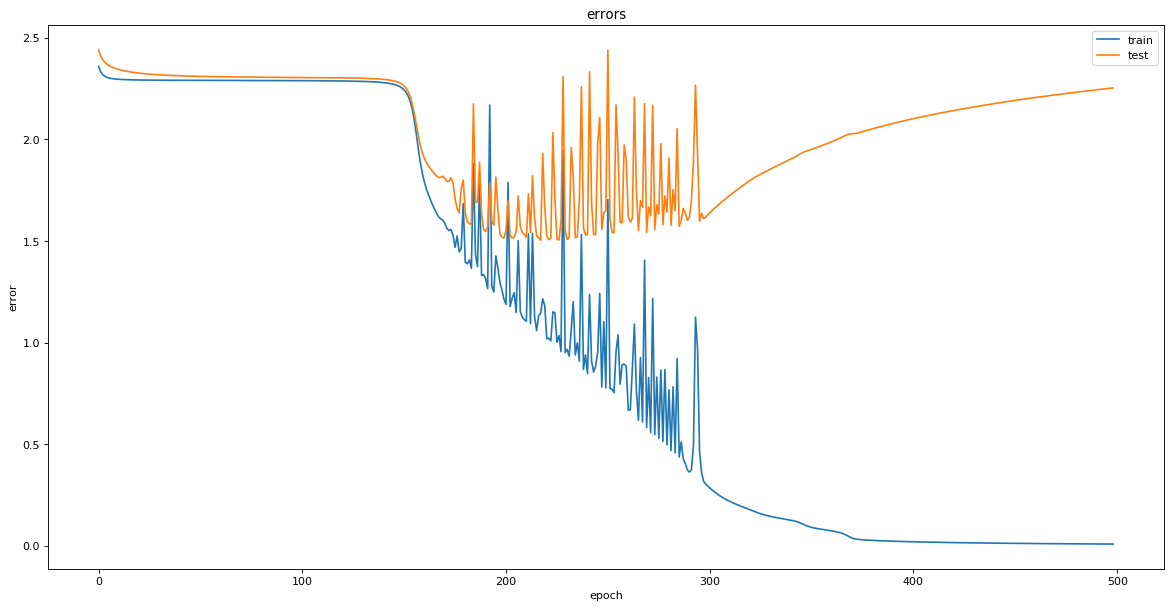

In [22]:
plot_train_test([train_log, test_log], 'loss')
# plot_train_test([train_log], 'loss')
# plot_train_test([test_log], 'loss')